# Importing all necessary libraries

In [ ]:
import sys
from tqdm import tqdm, trange
import numpy as np
from scipy.ndimage import convolve
import imageio.v2 as imageio
import random
import numba
from numba import jit
import numpy as np
from imageio import imread, imwrite
from tqdm import tqdm
import time
import matplotlib.pyplot as plt

# Brute Force Approach for Seam Carving

In [ ]:
def calc_energy(img):
    """Calculate the energy map of an image using the Sobel operator."""
    filter_du = np.array([
        [1.0, 2.0, 1.0],
        [0.0, 0.0, 0.0],
        [-1.0, -2.0, -1.0],
    ])
    filter_du = np.stack([filter_du] * 3, axis=2)  # Replicate for each color channel

    filter_dv = np.array([
        [1.0, 0.0, -1.0],
        [2.0, 0.0, -2.0],
        [1.0, 0.0, -1.0],
    ])
    filter_dv = np.stack([filter_dv] * 3, axis=2)  # Replicate for each color channel

    img = img.astype('float32')
    convolved = np.abs(convolve(img, filter_du)) + np.abs(convolve(img, filter_dv))
    energy_map = convolved.sum(axis=2)
    return energy_map

def random_seam(energy_map):
    r, c = energy_map.shape
    seam = np.zeros(r, dtype=int)
    seam[0] = random.randint(0, c - 1)

    for i in range(1, r):
        prev_x = seam[i-1]
        if prev_x == 0:
            options = [prev_x, prev_x+1]
        elif prev_x == c - 1:
            options = [prev_x-1, prev_x]
        else:
            options = [prev_x-1, prev_x, prev_x+1]
        seam[i] = min(options, key=lambda x: energy_map[i, x])

    return seam

def remove_seam(img, seam):
    r, c, _ = img.shape
    new_img = np.zeros((r, c-1, 3), dtype=img.dtype)
    for i in range(r):
        new_img[i, :, :] = np.delete(img[i, :, :], seam[i], axis=0)
    return new_img

def brute_force_seam_carve_scaled(img, scale_c, num_trials_per_seam=300):
    r, c, _ = img.shape
    new_c = int(scale_c * c)
    seams_to_remove = c - new_c

    for _ in tqdm(range(seams_to_remove), desc="Removing seams"):
        best_img = None
        min_energy = float('inf')
        energy_map = calc_energy(img)

        for _ in range(num_trials_per_seam):
            seam = random_seam(energy_map)
            img_with_seam_removed = remove_seam(img, seam)
            seam_energy = sum(energy_map[i, seam[i]] for i in range(r))
            if seam_energy < min_energy:
                min_energy = seam_energy
                best_img = img_with_seam_removed

        img = best_img  # Update img to the best found in this iteration

    return img

def brute_force_seam_carving(isRow, input_path, output_path, scale):

  try:
      img = imageio.imread(input_path)
      if isRow:
          img = np.rot90(img, 1, (0, 1))
          img = brute_force_seam_carve_scaled(img, scale)
          img = np.rot90(img, 3, (0, 1))
      else:
          img = brute_force_seam_carve_scaled(img, scale)
      imageio.imwrite(output_path, img)
      print(f"Resized image saved to {output_path}")
  except Exception as e:
      print(f"An error occurred: {e}")

# Dynamic Programming Approach for Seam Carving

In [ ]:
def calc_energy(img):
    filter_du = np.array([
        [1.0, 2.0, 1.0],
        [0.0, 0.0, 0.0],
        [-1.0, -2.0, -1.0],
    ])
    # This converts it from a 2D filter to a 3D filter, replicating the same
    # filter for each channel: R, G, B
    filter_du = np.stack([filter_du] * 3, axis=2)

    filter_dv = np.array([
        [1.0, 0.0, -1.0],
        [2.0, 0.0, -2.0],
        [1.0, 0.0, -1.0],
    ])
    # This converts it from a 2D filter to a 3D filter, replicating the same
    # filter for each channel: R, G, B
    filter_dv = np.stack([filter_dv] * 3, axis=2)

    img = img.astype('float32')
    convolved = np.absolute(convolve(img, filter_du)) + np.absolute(convolve(img, filter_dv))

    # We sum the energies in the red, green, and blue channels
    energy_map = convolved.sum(axis=2)

    return energy_map

def crop_c(img, scale_c):
    r, c, _ = img.shape
    new_c = int(scale_c * c)

    for i in trange(c - new_c):
        img = carve_column(img)

    return img

def crop_r(img, scale_r):
    img = np.rot90(img, 1, (0, 1))
    img = crop_c(img, scale_r)
    img = np.rot90(img, 3, (0, 1))
    return img

def carve_column(img):
    r, c, _ = img.shape

    M, backtrack = minimum_seam(img)
    mask = np.ones((r, c), dtype=bool)

    j = np.argmin(M[-1])
    for i in reversed(range(r)):
        mask[i, j] = False
        j = backtrack[i, j]

    mask = np.stack([mask] * 3, axis=2)
    img = img[mask].reshape((r, c - 1, 3))
    return img

def minimum_seam(img):
    r, c, _ = img.shape
    energy_map = calc_energy(img)

    M = energy_map.copy()
    backtrack = np.zeros_like(M, dtype=int)

    for i in range(1, r):
        for j in range(0, c):
            # Handle the left edge of the image, to ensure we don't index a -1
            if j == 0:
                idx = np.argmin(M[i-1, j:j + 2])
                backtrack[i, j] = idx + j
                min_energy = M[i-1, idx + j]
            else:
                idx = np.argmin(M[i - 1, j - 1:j + 2])
                backtrack[i, j] = idx + j - 1
                min_energy = M[i - 1, idx + j - 1]

            M[i, j] += min_energy

    return M, backtrack

def seam_carving_dynamic(isRow, scale, in_filename, out_filename):
    """Main function to apply seam carving for image resizing."""
    try:
        img = imageio.imread(in_filename)
        if isRow:
            img = crop_r(img, scale)
        else:
            img = crop_c(img, scale)
        imageio.imwrite(out_filename, img)
        print(f"Resized image saved to {out_filename}")
    except Exception as e:
        print(f"An error occurred: {e}")

# Greedy Approach for Seam Carving

In [ ]:
def calc_energy(img):
    """Calculate the energy map of an image using the Sobel operator."""
    filter_du = np.array([
        [1.0, 2.0, 1.0],
        [0.0, 0.0, 0.0],
        [-1.0, -2.0, -1.0],
    ])
    filter_du = np.stack([filter_du] * 3, axis=2)

    filter_dv = np.array([
        [1.0, 0.0, -1.0],
        [2.0, 0.0, -2.0],
        [1.0, 0.0, -1.0],
    ])
    filter_dv = np.stack([filter_dv] * 3, axis=2)

    img = img.astype('float32')
    convolved = np.abs(convolve(img, filter_du)) + np.abs(convolve(img, filter_dv))
    energy_map = convolved.sum(axis=2)
    return energy_map

def greedy_carve_column(img):
    """Carve one column based on a greedy approach from the energy map."""
    r, c, _ = img.shape
    energy_map = calc_energy(img)
    mask = np.ones((r, c), dtype=bool)

    # Start carving from the bottom row by finding the minimum energy
    j = np.argmin(energy_map[-1])
    for i in reversed(range(r)):
        mask[i, j] = False  # Remove the pixel with the least energy in current row
        # Update j for the next row to move to left, right, or stay
        if i > 0:
            if j == 0:
                j += np.argmin(energy_map[i-1, j:j+2])
            else:
                j += np.argmin(energy_map[i-1, max(j-1, 0):min(j+2, c)]) - 1


    mask = np.stack([mask] * 3, axis=2)
    img = img[mask].reshape((r, c - 1, 3))
    return img

def greedy_carve_row(img):
    """Carve one row based on a greedy approach from the energy map."""
    img = np.rot90(img, 1, (0, 1))
    img = greedy_carve_column(img)
    img = np.rot90(img, 3, (0, 1))
    return img

def greedy_crop_c(img, scale_c):
    """Resize image by cropping columns based on a greedy approach."""
    r, c, _ = img.shape
    new_c = int(scale_c * c)
    for _ in tqdm(range(c - new_c), desc='Greedy cropping columns'):
        img = greedy_carve_column(img)
    return img


def greedy_seam_carving(isRow, scale, in_filename, out_filename):
    """Main function to apply greedy seam carving for image resizing."""
    try:
        img = imageio.imread(in_filename)
        if isRow:
            img = np.rot90(img, 1, (0, 1))
            img = greedy_crop_c(img, scale)
            img = np.rot90(img, 3, (0, 1))
        else:
            img = greedy_crop_c(img, scale)
        imageio.imwrite(out_filename, img)
        print(f"Resized image saved to {out_filename}")
    except Exception as e:
        print(f"An error occurred: {e}")


In [ ]:
!mkdir /content/output

!mkdir /content/output/BRUTE
!mkdir /content/output/GREEDY
!mkdir /content/output/DYNAMIC

# Calculating the runtime and plotting the graphs

In [ ]:
# algorithms  = [brute_force_seam_carve_scaled, greedy_seam_carving, seam_carving_dynamic]
DEFAULT_PATH = "/content/pic"
DEFAULT_OUT = "/content/output/"
scale_factors = [0.9, 0.75, 0.5]
time_frames = {
    1:[],
    2:[],
    3:[]
}

for i in range(1,4):
  for scale in scale_factors:

    image_input_path = DEFAULT_PATH+str(i)+".jpg"

    dynamic_out_path = DEFAULT_OUT+"DYNAMIC/pic"+str(i)+"_"+str(scale*100)+"%.jpg"
    brute_out_path = DEFAULT_OUT+"BRUTE/pic"+str(i)+"_"+str(scale*100)+"%.jpg"
    greedy_out_path = DEFAULT_OUT+"GREEDY/pic"+str(i)+"_"+str(scale*100)+"%.jpg"

    tmp_time = []


    start = time.time()

    brute_force_seam_carving(True, image_input_path, brute_out_path, scale)

    end = time.time()

    tmp_time.append( end-start)


    start = time.time()
    greedy_seam_carving(True, scale, image_input_path, greedy_out_path)
    end = time.time()

    tmp_time.append( end-start)



    start = time.time()
    seam_carving_dynamic(True, scale, image_input_path, dynamic_out_path)

    end = time.time()

    tmp_time.append( end-start)

    time_frames[i].append(tuple(tmp_time))


Removing seams: 100%|██████████| 54/54 [02:37<00:00,  2.92s/it]


Resized image saved to /content/output/BRUTE/pic1_90.0%.jpg


Greedy cropping columns: 100%|██████████| 54/54 [00:05<00:00,  9.83it/s]


Resized image saved to /content/output/GREEDY/pic1_90.0%.jpg


100%|██████████| 54/54 [01:26<00:00,  1.60s/it]


Resized image saved to /content/output/DYNAMIC/pic1_90.0%.jpg


Removing seams: 100%|██████████| 134/134 [06:23<00:00,  2.86s/it]


Resized image saved to /content/output/BRUTE/pic1_75.0%.jpg


Greedy cropping columns: 100%|██████████| 134/134 [00:11<00:00, 11.21it/s]


Resized image saved to /content/output/GREEDY/pic1_75.0%.jpg


100%|██████████| 134/134 [03:16<00:00,  1.47s/it]


Resized image saved to /content/output/DYNAMIC/pic1_75.0%.jpg


Removing seams: 100%|██████████| 267/267 [12:25<00:00,  2.79s/it]


Resized image saved to /content/output/BRUTE/pic1_50.0%.jpg


Greedy cropping columns: 100%|██████████| 267/267 [00:21<00:00, 12.69it/s]


Resized image saved to /content/output/GREEDY/pic1_50.0%.jpg


100%|██████████| 267/267 [05:12<00:00,  1.17s/it]


Resized image saved to /content/output/DYNAMIC/pic1_50.0%.jpg


Removing seams: 100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


Resized image saved to /content/output/BRUTE/pic2_90.0%.jpg


Greedy cropping columns: 100%|██████████| 15/15 [00:00<00:00, 120.01it/s]


Resized image saved to /content/output/GREEDY/pic2_90.0%.jpg


100%|██████████| 15/15 [00:02<00:00,  6.10it/s]


Resized image saved to /content/output/DYNAMIC/pic2_90.0%.jpg


Removing seams: 100%|██████████| 37/37 [00:30<00:00,  1.21it/s]


Resized image saved to /content/output/BRUTE/pic2_75.0%.jpg


Greedy cropping columns: 100%|██████████| 37/37 [00:00<00:00, 134.13it/s]


Resized image saved to /content/output/GREEDY/pic2_75.0%.jpg


100%|██████████| 37/37 [00:04<00:00,  8.73it/s]


Resized image saved to /content/output/DYNAMIC/pic2_75.0%.jpg


Removing seams: 100%|██████████| 74/74 [01:00<00:00,  1.23it/s]


Resized image saved to /content/output/BRUTE/pic2_50.0%.jpg


Greedy cropping columns: 100%|██████████| 74/74 [00:00<00:00, 151.38it/s]


Resized image saved to /content/output/GREEDY/pic2_50.0%.jpg


100%|██████████| 74/74 [00:08<00:00,  8.96it/s]


Resized image saved to /content/output/DYNAMIC/pic2_50.0%.jpg


Removing seams: 100%|██████████| 28/28 [01:13<00:00,  2.63s/it]


Resized image saved to /content/output/BRUTE/pic3_90.0%.jpg


Greedy cropping columns: 100%|██████████| 28/28 [00:01<00:00, 21.07it/s]


Resized image saved to /content/output/GREEDY/pic3_90.0%.jpg


100%|██████████| 28/28 [00:21<00:00,  1.29it/s]


Resized image saved to /content/output/DYNAMIC/pic3_90.0%.jpg


Removing seams: 100%|██████████| 70/70 [03:02<00:00,  2.61s/it]


Resized image saved to /content/output/BRUTE/pic3_75.0%.jpg


Greedy cropping columns: 100%|██████████| 70/70 [00:02<00:00, 23.73it/s]


Resized image saved to /content/output/GREEDY/pic3_75.0%.jpg


100%|██████████| 70/70 [00:49<00:00,  1.42it/s]


Resized image saved to /content/output/DYNAMIC/pic3_75.0%.jpg


Removing seams: 100%|██████████| 139/139 [05:58<00:00,  2.58s/it]


Resized image saved to /content/output/BRUTE/pic3_50.0%.jpg


Greedy cropping columns: 100%|██████████| 139/139 [00:05<00:00, 23.26it/s]


Resized image saved to /content/output/GREEDY/pic3_50.0%.jpg


100%|██████████| 139/139 [01:24<00:00,  1.65it/s]

Resized image saved to /content/output/DYNAMIC/pic3_50.0%.jpg


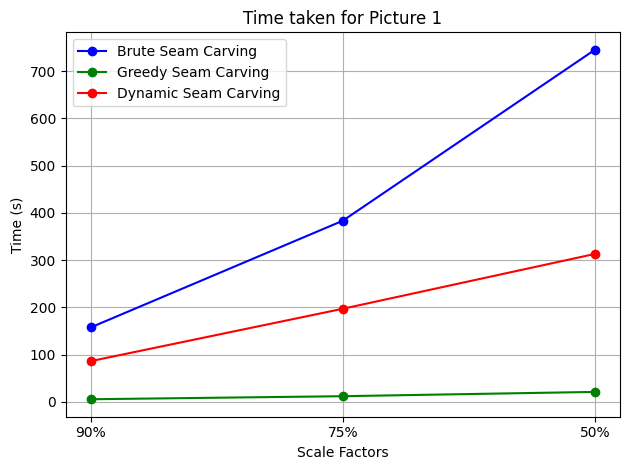

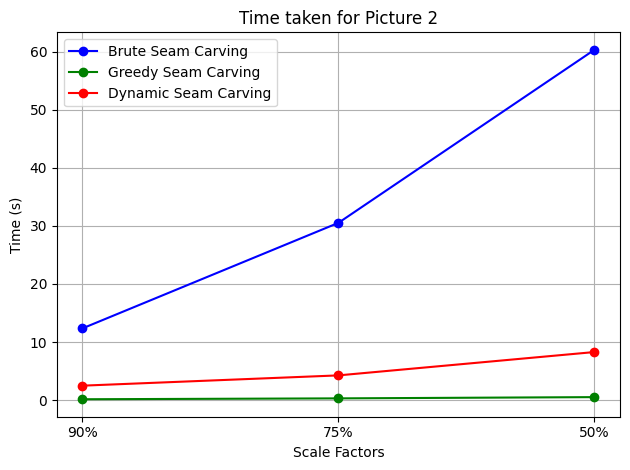

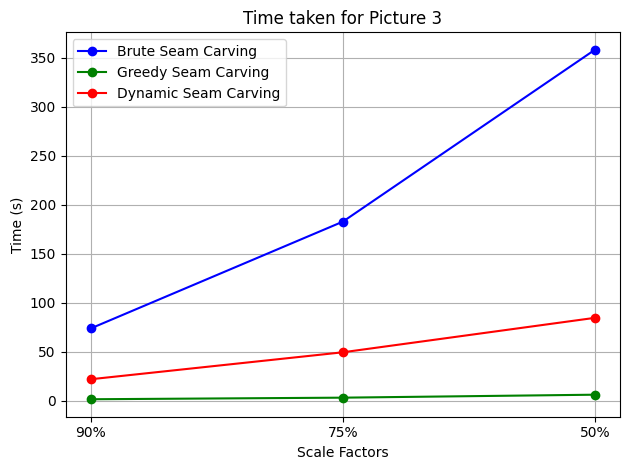

In [ ]:
colors = ['b', 'g', 'r']

# Algorithm names
algo_names = ['Brute Seam Carving', 'Greedy Seam Carving', 'Dynamic Seam Carving']

# Create a function to plot for each picture
def plot_picture_times(pic_index):
    # Get the times for this picture
    pic_times = time_frames[pic_index]

    # Create figure and axes
    fig, ax = plt.subplots()

    # Set the x locations for the groups
    scale_factors_str = [f'{int(scale*100)}%' for scale in scale_factors]
    x = np.arange(len(scale_factors_str))

    # Plot lines for each algorithm
    for i, color in enumerate(colors):
        times = [t[i] for t in pic_times]
        ax.plot(x, times, marker='o', linestyle='-', color=color, label=algo_names[i])

    # Add some text for labels, title and axes ticks
    ax.set_xlabel('Scale Factors')
    ax.set_ylabel('Time (s)')
    ax.set_title(f'Time taken for Picture {pic_index}')
    ax.set_xticks(x)
    ax.set_xticklabels(scale_factors_str)
    ax.legend()

    # Show grid for better readability
    ax.grid(True)

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

# Call the function for each picture
for i in range(1, 4):
    plot_picture_times(i)